In [0]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec


In [39]:
from google.colab import files 

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data_3000.zip to data_3000 (1).zip
User uploaded file "data_3000.zip" with length 3309996 bytes


In [0]:
! mkdir data_3000
! unzip data_3000.zip -d ./data_3000

In [41]:
%tensorflow_version 2.x
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split



TensorFlow is already loaded. Please restart the runtime to change versions.


0


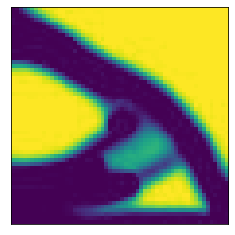

1


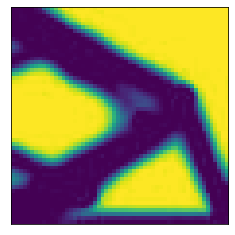

2


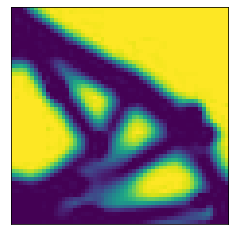

X_shape: (56, 56) Y_shape: ()
X_list shape: (3000, 56, 56) Y_list shape: (3000,)


In [42]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 

src = './data_3000/'

def img_read_plot(src,file):
    img = cv.imread(src + file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()
    return img

def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

files = os.listdir(src)

X,Y = [],[]
count = 0

for file in files: 
  # Visualized 3 sample images
  # Normalized the image pixel range to 0~1
  if count < 3 :  
    print(count)
    X.append(img_read_plot(src,file)/255.)
    Y.append(float(file[:-4]))
    count+=1
  else : 
    X.append(img_read(src,file)/255.)
    Y.append(float(file[:-4]))

X = np.array(X)
Y = np.array(Y)

#Image size check
print('X_shape:',np.shape(X[0]),'Y_shape:',np.shape(Y[0]))
print('X_list shape:',np.shape(X),'Y_list shape:',np.shape(Y))

In [0]:
# Hyperparamenters
learning_rate = 0.001
training_epochs = 1000
batch_size = 32 
Buffer_size = 100

In [44]:
#Images are splitted to 80:20 ratio
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

print(np.shape(train_images))
print(np.shape(test_images))
print(np.shape(train_labels))
print(np.shape(test_labels))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(Buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)



(2400, 56, 56, 1)
(600, 56, 56, 1)
(2400,)
(600,)


In [0]:
#Convolutional Net
class ConvBNRelu(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5), strides=strides, 
                                        padding=padding, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [0]:
#Fully Connected net 
class DenseBNRelu(tf.keras.Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal',kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5))
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [0]:
#Final Model 
class AllModels(tf.keras.Model):
    def __init__(self):
        super(AllModels, self).__init__()
        self.conv1 = ConvBNRelu(filters=32)        
        self.pool1 = keras.layers.MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64)
        self.pool2 = keras.layers.MaxPool2D()
        self.conv3 = ConvBNRelu(filters=128)
        self.pool3 = keras.layers.MaxPool2D()
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=1)
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [60]:
#Summary of the model
model=AllModels()

temp_inputs = keras.Input(shape=(56, 56, 1))
model(temp_inputs)
model.summary()

Model: "all_models_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu_15 (ConvBNRelu) (None, 56, 56, 32)        448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv_bn_relu_16 (ConvBNRelu) (None, 28, 28, 64)        18752     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv_bn_relu_17 (ConvBNRelu) (None, 14, 14, 128)       74368     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)             

In [0]:
#To calculate the validation accuracy using Root Mean Square Error(RMSE) & Mean Absolute Percentage Error(MAPE)
import keras.backend as K

def rmse (y_true, y_pred):  
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

model.compile(loss='MSE', optimizer='adam', metrics=[ rmse, 'mape' ]) 

history = model.fit(train_images, train_labels,      
          batch_size=batch_size,                      
          epochs=training_epochs,                    
          verbose=1,                                 
          validation_data=(test_images, test_labels)) 

score = model.evaluate(test_images, test_labels, verbose=0) 

print('Test loss(mse) :', score[0])
print('Test RMSE :', score[1])
print('Test MAPE :', score[2])

Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 27s 11ms/sample - loss: 519.8381 - rmse: 22.5747 - mean_absolute_percentage_error: 82.9890 - val_loss: 472.5247 - val_rmse: 21.6839 - val_mean_absolute_percentage_error: 79.8474
Epoch 2/1000
2400/2400 [==============================] - 26s 11ms/sample - loss: 197.4594 - rmse: 13.6398 - mean_absolute_percentage_error: 50.1414 - val_loss: 191.0527 - val_rmse: 13.7407 - val_mean_absolute_percentage_error: 50.5253
Epoch 3/1000
2400/2400 [==============================] - 26s 11ms/sample - loss: 45.8796 - rmse: 5.9901 - mean_absolute_percentage_error: 21.9982 - val_loss: 74.1847 - val_rmse: 8.4384 - val_mean_absolute_percentage_error: 30.9827
Epoch 4/1000
2400/2400 [==============================] - 26s 11ms/sample - loss: 13.6339 - rmse: 3.0044 - mean_absolute_percentage_error: 11.0241 - val_loss: 33.2199 - val_rmse: 5.4880 - val_mean_absolute_percentage_error: 20.1637
Epoch 5/1000
2400

In [0]:

#still working on augmentaion, ensemble coding..